In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.neural_network import BernoulliRBM

from collections import Counter

from imblearn.metrics import classification_report_imbalanced

n_samples=50000
n_features=20
RANDOM_STATE = 42

X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2,\
                           n_clusters_per_class=2, weights=[0.9,0.1], flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0,\
                           scale=1.0, shuffle=True, random_state=None)
y=np.array(y)
X=np.array(X)
y=np.reshape(y,(n_samples, 1))
X=np.reshape(X, (n_samples, n_features))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


C:\Users\Snir\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [3]:
#custom scoring function sklearn
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
def lift_index(y, probabilities):
    #rearrange probabilities and y in descending order
    probabilities = probabilities.ravel()
    combine = list(zip(y, probabilities))
    dtype = [('data', int), ('prob', float)]
    combine = np.array(combine,dtype=dtype)
    combine = np.sort(combine, order='prob') #sort according to probabilities
    ordered = np.sort(probabilities) #sort probabilities
    #divide into deciles
    deciles = pd.qcut(ordered, 10, duplicates='drop', labels=False) #creates array of digits from 1 to 10
    #sum of positive in each decile-if negative then zero and doesn't get taken into account
    sum_deciles = sum([((val+1)/10)*combine[num][0] for num, val in enumerate(deciles)])
    return sum_deciles/sum(y)
lift_index_score = make_scorer(lift_index, greater_is_better=True, needs_proba=True )



In [4]:

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.noise import AlphaDropout
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.initializers import lecun_uniform
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from sklearn.svm import LinearSVC

from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.externals import joblib
from imblearn.pipeline import make_pipeline
def construct_model(layers=[50,50], activation='relu', b_init='random_uniform', k_init='random_uniform', dropout=.0,\
                    a_dropout=.0, optimizer='sgd', loss='binary_crossentropy', metrics='roc_auc_score',input_dim=20, output_dim=1, model_name='most'):
    """
    Helper to construct a Keras model based on dict of specs and input size

    Parameters
    ----------
    model_spec: dict
        Dict containing keys: arch, activation, dropout, optimizer, loss,
            w_reg, metrics
    input_dim: int
        Size of input dimension
    output_dim: int
        Size of input dimension

    Returns
    -------
    model: Compiled keras.models.Sequential

    """

    model = Sequential()

    for li, layer_size in enumerate(layers):
        # For input layer, add input dimension
        if li == 0:
            temp_input_dim = input_dim
            model.add(Dense(layer_size,
                            input_dim=temp_input_dim,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Input'))
        elif li < len(layers)-1:
            model.add(Dense(layer_size,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
        elif li == len(layers)-1:
            model.add(Dense( output_dim ,
                            activation='sigmoid',
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
            
        if dropout > 0. :
            if a_dropout == 0.:
                model.add(Dropout(dropout, name='Dropout_%i' % li))
        if a_dropout > 0.:
            model.add(Dropout(a_dropout, name='Dropout_%i' % li))
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics],
                 loss_weights=[2])
    #keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, save_best_only=True, \
    #                                write_graph=True, write_images=False)

    return model 
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
pipe = make_pipeline( SMOTEENN(ratio='minority', random_state=RANDOM_STATE, smote=None, enn=None, k=None, m=None,\
                      out_step=None, kind_smote=None, size_ngh=None, n_neighbors=None, kind_enn=None, n_jobs=None),\
                      BernoulliRBM(n_components=256, learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=RANDOM_STATE),\
                      KerasClassifier(build_fn=construct_model, epochs=10, batch_size=128, validation_split=0.2))

Using TensorFlow backend.


In [5]:
#import data without any dummy variables or changes
from sklearn.model_selection import GridSearchCV

param_grid = {'kerasclassifier__layers': [[100,100]],
              'kerasclassifier__input_dim': [50],
              'kerasclassifier__activation':['selu'],
              'kerasclassifier__dropout': [0.],
              'kerasclassifier__a_dropout': [0.2],
              'kerasclassifier__k_init': ['lecun_normal'],
              'kerasclassifier__b_init': ['lecun_normal'],
              'kerasclassifier__optimizer':['adam'],
              'kerasclassifier__metrics' : ['accuracy'],
              'kerasclassifier__epochs':[10],
              'kerasclassifier__batch_size':[32],
              'bernoullirbm__n_components':[50],
              'bernoullirbm__learning_rate':[0.05],
              'bernoullirbm__n_iter':[30]    }

#improve with article
grid = GridSearchCV(pipe,
                    param_grid,
                    return_train_score=True,
                    refit=True,
                    scoring='roc_auc',
                    verbose=15)

In [6]:
grid.fit(X_train, y_train.ravel())
print(grid.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] bernoullirbm__learning_rate=0.05, bernoullirbm__n_components=50, bernoullirbm__n_iter=30, kerasclassifier__a_dropout=0.2, kerasclassifier__activation=selu, kerasclassifier__b_init=lecun_normal, kerasclassifier__batch_size=32, kerasclassifier__dropout=0.0, kerasclassifier__epochs=10, kerasclassifier__input_dim=50, kerasclassifier__k_init=lecun_normal, kerasclassifier__layers=[100, 100], kerasclassifier__metrics=accuracy, kerasclassifier__optimizer=adam 
Train on 29341 samples, validate on 7336 samples
Epoch 1/10
29341/29341 [==============================] - 2s 74us/step - loss: 3.3822 - acc: 0.8003 - val_loss: 1.3117 - val_acc: 0.9323

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Train on 29276 samples, validate on 7319 samples
Epoch 1/10
29276/29276 [==============================] - 2s 75us/step - loss: 3.3792 - acc: 0.8200 - val_loss: 1.2841 - val_acc: 0.9269

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Train on 29401 samples, validate on 7351 samples
Epoch 1/10
29401/29401 [==============================] - 2s 76us/step - loss: 3.3835 - acc: 0.8158 - val_loss: 1.3458 - val_acc: 0.9308

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


Train on 44068 samples, validate on 11018 samples
Epoch 1/10
44068/44068 [==============================] - 3s 68us/step - loss: 3.6241 - acc: 0.8132 - val_loss: 1.3189 - val_acc: 0.9319

stratified generates random predictions by respecting the training set class distribution.
most_frequent always predicts the most frequent label in the training set.
prior always predicts the class that maximizes the class prior (like most_frequent`) and ``predict_proba returns the class prior.
uniform generates predictions uniformly at random.
constant always predicts a constant label that is provided by the user.

In [7]:
#from sklearn.dummy import DummyClassifier 
#
#clf = DummyClassifier(strategy='most_frequent',random_state=0)
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)  

In [8]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#and use helper functions above to show output
#visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.utils import plot_model
#visualize best model
model=grid
n_classes = 2
model_name = 'dense'
#best ampling
sme = SMOTEENN(ratio='minority', random_state=RANDOM_STATE, smote=None, enn=None, k=None, m=None,\
                      out_step=None, kind_smote=None, size_ngh=None, n_neighbors=None, kind_enn=None, n_jobs=None)
X_res, y_res = sme.fit_sample(X_train, y_train.ravel())
#best rbm
rbm = BernoulliRBM(n_components=model.best_params_['bernoullirbm__n_components'], learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=RANDOM_STATE)
X_rbm = rbm.fit_transform(X_res)

best = construct_model( layers=model.best_params_['kerasclassifier__layers'],
                        activation=model.best_params_['kerasclassifier__activation'],
                        b_init=model.best_params_['kerasclassifier__b_init'],
                        k_init=model.best_params_['kerasclassifier__k_init'],
                        dropout=model.best_params_['kerasclassifier__dropout'],
                        a_dropout=model.best_params_['kerasclassifier__a_dropout'],
                        optimizer=model.best_params_['kerasclassifier__optimizer'],
                        metrics=model.best_params_['kerasclassifier__metrics'],
                        input_dim=model.best_params_['bernoullirbm__n_components'])
best.fit(X_rbm, y_res, epochs=10)
#compute lift index from best model only at first
lift = lift_index(y_res, best.predict(X_rbm))
plot_confusion_matrix(confusion_matrix(best.predict_classes(X_rbm), y_res), ['neg', 'pos'])
print(lift)

Epoch 1/10
55086/55086 [==============================] - 3s 61us/step - loss: 3.9936 - acc: 0.8124

Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


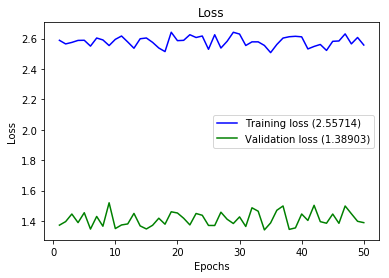

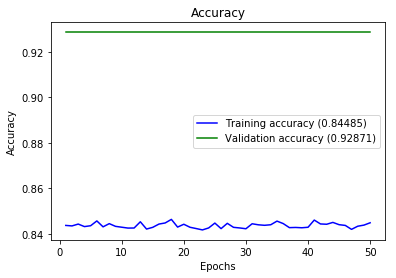

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.87      0.93      0.89      0.90      0.81     25059
          1       0.89      0.93      0.87      0.91      0.90      0.81     30027

avg / total       0.90      0.90      0.89      0.90      0.90      0.81     55086



In [ ]:
plot_history(best.fit(X_rbm, y_res, validation_split=0.33, epochs=50, batch_size=10, verbose=10))
#plot_history(grid.best_estimator_) #use another function
print(classification_report_imbalanced(y_res, best.predict_classes(X_rbm)))

In [ ]:
#sess.close()